# Hungarian Algorithm

Here we briefly look at the Hungarian algorithm, which is a method that can be used to align cluster ID's from run to run, so that appropriate comparisons can be made. It is based off the **Assignment Problem** in which you wish to assign N workers to N tasks and minimize the 'cost' (ie time spent, overall cost, etc) of doing so. This can be represented as a cost matrix, where only one element from each row/column may be chosen. 

<img src="../Images/assignment_problem.png" title="Assignment Problem" width="40%" height="40%" align="left"/>
<BR CLEAR="left">
    
We can reframe the assignment problem as a cluster identity problem. Suppose we have 2 clustering solutions that have clustered some dataset, but due to the arbitrary initial cluster locations, what solution 1 labels as cluster 1, solution 2 might label as cluster 2. As a concrete example, this might look like:

<img src="../Images/clustering_ids.png" title="Assignment Problem" width="40%" height="40%" align="left"/>
<BR CLEAR="left">
    
In this example, algorithm 1 and algorithm 2 seem to have swapped which ones they call cluster 1 and 2. So what we wish to do is actually choose the row/columns that maximize the 'cost' of this confusion matrix. 

Or, we can minimize the negative of the confusion matrix, and then exactly use the Hungarian method to re-assign our labels. 

Let's see this in action... 

(Note that I didn't go through the details of how to actually perform the Hungarian Algorithm... it's simple in practice but probably tricky to implement on a computer: scipy to the rescue... `linear_sum_assignment` already does exactly what we want). 

In [2]:
# Standard Stuff
import numpy as np
import pandas as pd

# Clustering Stuff
from sklearn.cluster import KMeans

# Hungarian Algorithm Stuff
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

# Make a dataset Stuff
from sklearn.datasets import make_blobs

# Plotting Stuff
import matplotlib
import matplotlib.pyplot as plt

# Other Stuff
from sklearn.utils import resample

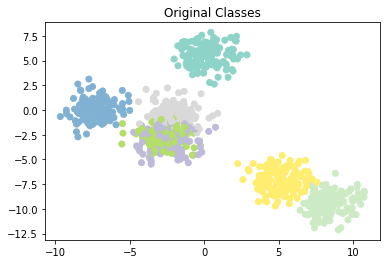

In [163]:
# Set up some simple data
n_centers = 7
n_clusters = 7
n_data = 1000

centroids_bad = np.array([[-2,8],[4,-5],[9,-7],[1,5],[-7,8],[-6,-5],[7,6],[5,-1],[-10,0],[0,0]])
x,y = make_blobs(n_data, centers = n_centers)

fig1,ax1 = plt.subplots()
plt.scatter(x[np.arange(n_data),0],x[np.arange(n_data),1],c=y[np.arange(n_data)],cmap=plt.cm.Set3)
plt.title('Original Classes')
plt.show()

In [164]:
km = KMeans(n_clusters = n_clusters)

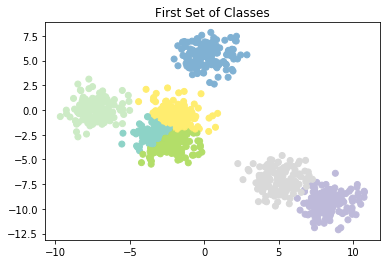

In [165]:
# Let's run k-means once
km = KMeans(n_clusters = n_clusters)
x_id1 = km.fit_predict(x)
plt.scatter(x[np.arange(n_data),0],x[np.arange(n_data),1],c=x_id1[np.arange(n_data)],cmap=plt.cm.Set3)
plt.title('First Set of Classes')
plt.show()

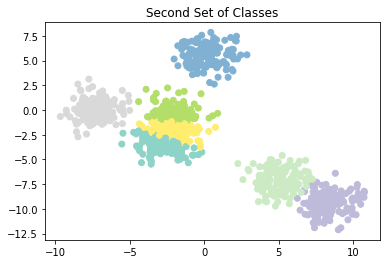

In [166]:
# Let's run it again: notice how the labels (colors) don't line up
x_id2 = km.fit_predict(x)
plt.scatter(x[np.arange(n_data),0],x[np.arange(n_data),1],c=x_id2[np.arange(n_data)],cmap=plt.cm.Set3)
plt.title('Second Set of Classes')
plt.show()

In [167]:
# Force the second set to match the first set
# Column will be reference (predicted), row will be the new match ids
# Want to maximize the diagonal, so minimize the negative

cm = confusion_matrix(x_id2,x_id1)
opt_row, opt_col = linear_sum_assignment(-cm)

# switch cluster id's to those maximized by diagonal of cm
x_id2_new = np.zeros(x_id2.shape)
for ii in range(n_clusters):
    new_id = opt_col[ii]
    idxs = x_id2==ii
    x_id2_new[idxs]=new_id

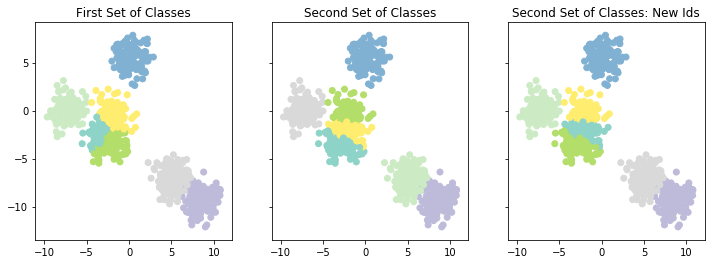

In [168]:
# After we have swapped the labels, we now have matching IDs
fig1,ax1 = plt.subplots(1,3,figsize=(12, 4),sharey=True,sharex=True)
plt.sca(ax1[0])
plt.scatter(x[np.arange(n_data),0],x[np.arange(n_data),1],c=x_id1[np.arange(n_data)],cmap=plt.cm.Set3)
plt.title('First Set of Classes')

plt.sca(ax1[1])
plt.scatter(x[np.arange(n_data),0],x[np.arange(n_data),1],c=x_id2[np.arange(n_data)],cmap=plt.cm.Set3)
plt.title('Second Set of Classes')

plt.sca(ax1[2])
plt.scatter(x[np.arange(n_data),0],x[np.arange(n_data),1],c=x_id2_new[np.arange(n_data)],cmap=plt.cm.Set3)
plt.title('Second Set of Classes: New Ids')
plt.show()

In [169]:
# Do this n_bootstrap times, for example, get average cluster assignments for each point
# IMPORTANT: when doing this, we want to resample our data but this means each bootstrap sample will have different samples
# Thus to use the Hungarian method, we can only compare those samples that showed up in both bootstrap samples
# Or maybe, fit on the subsample but then predict on all samples (so every original data point gets clustered, but only based on some subset)

# First, add a sample label to our data
sample_id = np.arange(n_data).reshape(-1,1)
x_labeled = np.append(sample_id,x, axis=1)

n_bootstrap = 100

# do a first bootstrap that will be used as the consistent reference set throughout the rest of the bootstraps
x_ref = resample(x_labeled)
x_ref_sample_id = x_ref[:,0]
x_ref_data = x_ref[:,1:]
km = KMeans(n_clusters = n_clusters)
km.fit(x_ref_data)
x_ref_cluster_id = km.predict(x)

# get average cluster centers as well
cluster_dict = {}
clusters = km.cluster_centers_
for ii in range(n_clusters):
    cluster_dict[ii] = [clusters[ii]]

id_array = np.zeros((n_bootstrap, n_data))
id_array[0,:] = x_ref_cluster_id

for jj in range(1,n_bootstrap):
    # Get Sample 
    x_new = resample(x_labeled)
    x_new_sample_id = x_ref[:,0]
    x_new_data = x_ref[:,1:]
    km = KMeans(n_clusters = n_clusters)
    km.fit(x_new_data)
    clusters = km.cluster_centers_
    
    x_new_cluster_id = km.predict(x)
    cm = confusion_matrix(x_new_cluster_id,x_ref_cluster_id)
    opt_row, opt_col = linear_sum_assignment(-cm)
    
    # switch cluster id's to those maximized by diagonal of cm
    x_new_cluster_id_revised = np.zeros(x_new_cluster_id.shape)
    for ii in range(n_clusters):
        ## ii is the old id, new_id is the new_id 
        new_id = opt_col[ii]
        idxs = x_new_cluster_id==ii
        x_new_cluster_id_revised[idxs]=new_id
        # add the new clusters as well
        cluster_dict[new_id].append(clusters[ii])
        
    id_array[jj,:] = x_new_cluster_id_revised
    
    

In [170]:
# Get average location of clusters, along with standard deviations
n_features = x.shape[1]
cluster_array = np.zeros((n_clusters,n_features*2))
for ii in range(n_clusters):
    cluster_ii = cluster_dict[ii]
    cluster_ii = np.array(cluster_ii)
    avg = np.mean(cluster_ii,axis=0)
    std = np.std(cluster_ii,axis=0)
    cluster_array[ii,:n_features] = avg
    cluster_array[ii,n_features:]=std

cluster_array    

array([[-2.88477836e+00, -2.46584479e+00,  1.60184356e+00,
         1.15582330e+00],
       [ 8.45788145e+00, -9.40885644e+00,  2.28002359e-02,
         1.36095660e-01],
       [ 8.23195589e-02,  5.58793494e+00,  1.24900090e-16,
         7.99360578e-15],
       [ 5.21398348e+00, -7.16929584e+00,  2.59688820e-02,
         4.88518539e-03],
       [-7.21562523e+00,  7.73803876e-02,  5.32907052e-15,
         0.00000000e+00],
       [-1.84337861e+00, -6.31776401e-01,  6.98851363e-02,
         9.01776959e-02],
       [-2.12251343e+00, -3.61648387e+00,  1.71946815e-01,
         2.11734843e-01]])

In [171]:
df = pd.DataFrame(id_array)

df_stats = df.describe()

df_stats

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
count,100.0,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.0,100.000000,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.000000,100.0,100.0
mean,2.0,5.0,5.580000,2.0,2.0,4.900000,0.450000,0.780000,1.0,0.980000,...,2.0,3.0,4.0,1.0,2.0,4.0,2.0,4.960000,6.0,1.0
std,0.0,0.0,1.538594,0.0,0.0,0.703526,1.438117,2.027986,0.0,0.140705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.751026,0.0,0.0
min,2.0,5.0,0.000000,2.0,2.0,0.000000,0.000000,0.000000,1.0,0.000000,...,2.0,3.0,4.0,1.0,2.0,4.0,2.0,0.000000,6.0,1.0
25%,2.0,5.0,6.000000,2.0,2.0,5.000000,0.000000,0.000000,1.0,1.000000,...,2.0,3.0,4.0,1.0,2.0,4.0,2.0,5.000000,6.0,1.0
50%,2.0,5.0,6.000000,2.0,2.0,5.000000,0.000000,0.000000,1.0,1.000000,...,2.0,3.0,4.0,1.0,2.0,4.0,2.0,5.000000,6.0,1.0
75%,2.0,5.0,6.000000,2.0,2.0,5.000000,0.000000,0.000000,1.0,1.000000,...,2.0,3.0,4.0,1.0,2.0,4.0,2.0,5.000000,6.0,1.0
max,2.0,5.0,6.000000,2.0,2.0,5.000000,5.000000,6.000000,1.0,1.000000,...,2.0,3.0,4.0,1.0,2.0,4.0,2.0,6.000000,6.0,1.0


In [172]:
outliers = []
outliers_idx = []
perc = []
median_list = []
perc_required = 0.95
for ii in range(n_data):
    median_val = np.median(df.iloc[:,ii])
    perc_included = np.mean(df.iloc[:,ii]==median_val)
    median_list.append(median_val)
    perc.append(perc_included)
    if perc_included<perc_required:
        print(perc_included)
        outliers.append(x[ii])
        outliers_idx.append(ii)

outliers = np.array(outliers)

0.93
0.91
0.87
0.93
0.55
0.93
0.93
0.93
0.86
0.92
0.57
0.93
0.91
0.86
0.93
0.91
0.87
0.93
0.94
0.91
0.94
0.63
0.79
0.91
0.88
0.92
0.91
0.84
0.84
0.77
0.79
0.91
0.93
0.91
0.93
0.89
0.93
0.88
0.93
0.93
0.91
0.93
0.91
0.84
0.93
0.94
0.88
0.93
0.86
0.93
0.8
0.92
0.51
0.86
0.8
0.91
0.79
0.94
0.93
0.91
0.91
0.91
0.93
0.79
0.93
0.93
0.93
0.93
0.91
0.92
0.93
0.93
0.86
0.78
0.84
0.77
0.91
0.93
0.93
0.93
0.93
0.8
0.71
0.89
0.93
0.93
0.93
0.81
0.93
0.93
0.36
0.91
0.91
0.78
0.93
0.91
0.92
0.71
0.85
0.88
0.7
0.57
0.91
0.94
0.82
0.91
0.56
0.93
0.89
0.91
0.68
0.91
0.64
0.93
0.93
0.93
0.93
0.93
0.59
0.69
0.93
0.93
0.93
0.84
0.84
0.79
0.76
0.8
0.93
0.93
0.87
0.89
0.92


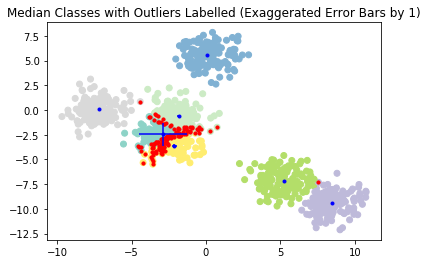

In [176]:
error_magnify = 1
plt.scatter(x[np.arange(n_data),0], x[np.arange(n_data),1],c=median_list,cmap=plt.cm.Set3)
plt.scatter(outliers[:,0],outliers[:,1], c='r', s=10, marker='o')
plt.errorbar(cluster_array[:,0],cluster_array[:,1],error_magnify*cluster_array[:,3],error_magnify*cluster_array[:,2], c = 'b',marker='.',linestyle='None')
plt.title('Median Classes with Outliers Labelled (Exaggerated Error Bars by {:d})'.format(error_magnify))
plt.show()